import packages and necessary data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB/pitch_value')
count_data = pd.read_csv('./data/datasets/combined_counts.csv')
statcast_woba = pd.read_csv('./data/datasets/cleaned_pitch_2024.csv')

code for assigning ball strike wobas is in cleaning

In [5]:
import numpy as np

# Define the number of zones in each dimension
n_horizontal_zones = 14  # Increased horizontal zones
n_vertical_zones = 14   # Increased vertical zones

# Define the limits of the extended strike zone
horizontal_zone_left = -2.5  # Extend further to the left
horizontal_zone_right = 2.5   # Extend further to the right
vertical_zone_bottom = -0.5   # Extend further down
vertical_zone_top = 5.75     # Extend further up

# Calculate the width and height of each zone
zone_width = (horizontal_zone_right - horizontal_zone_left) / n_horizontal_zones
zone_height = (vertical_zone_top - vertical_zone_bottom) / n_vertical_zones

# Create lists to store the zone coordinates
horizontal_bins = np.linspace(horizontal_zone_left, horizontal_zone_right, n_horizontal_zones + 1)
vertical_bins = np.linspace(vertical_zone_bottom, vertical_zone_top, n_vertical_zones + 1)

# Assign each pitch to a zone
statcast_woba['horizontal_zone'] = pd.cut(statcast_woba['horz_position_of_pitch'], bins=horizontal_bins, labels=False, include_lowest=True)
statcast_woba['vertical_zone'] = pd.cut(statcast_woba['vertical_pos_of_pitch'], bins=vertical_bins, labels=False, include_lowest=True)

# Calculate the average WOBA for each zone
zone_woba = statcast_woba.groupby(['horizontal_zone', 'vertical_zone'])['estimated_woba'].mean().reset_index()

# Calculate the percentage of called strikes for each zone
zone_counts = statcast_woba.groupby(['horizontal_zone', 'vertical_zone'])['called_strike'].count().reset_index()
zone_called_strikes = statcast_woba.groupby(['horizontal_zone', 'vertical_zone'])['called_strike'].sum().reset_index()

# Merge the counts and called strikes
zone_data = pd.merge(zone_counts, zone_called_strikes, on=['horizontal_zone', 'vertical_zone'], suffixes=('_count', '_called_strike'))

# Calculate the percentage of called strikes
zone_data['percent_called_strike'] = zone_data['called_strike_called_strike'] / zone_data['called_strike_count']

# Merge the percentage of called strikes into the zone_woba DataFrame
zone_woba = pd.merge(zone_woba, zone_data[['horizontal_zone', 'vertical_zone', 'percent_called_strike']], on=['horizontal_zone', 'vertical_zone'], how='left')


print(zone_woba)


     horizontal_zone  vertical_zone  estimated_woba  percent_called_strike
0                0.0            0.0        0.115366                    0.0
1                0.0            1.0        0.217787                    0.0
2                0.0            2.0        0.164301                    0.0
3                0.0            3.0        0.102222                    0.0
4                0.0            4.0        0.092410                    0.0
..               ...            ...             ...                    ...
190             13.0            8.0        0.146878                    0.0
191             13.0            9.0        0.151670                    0.0
192             13.0           10.0        0.165075                    0.0
193             13.0           11.0        0.119656                    0.0
194             13.0           12.0        0.116975                    0.0

[195 rows x 4 columns]


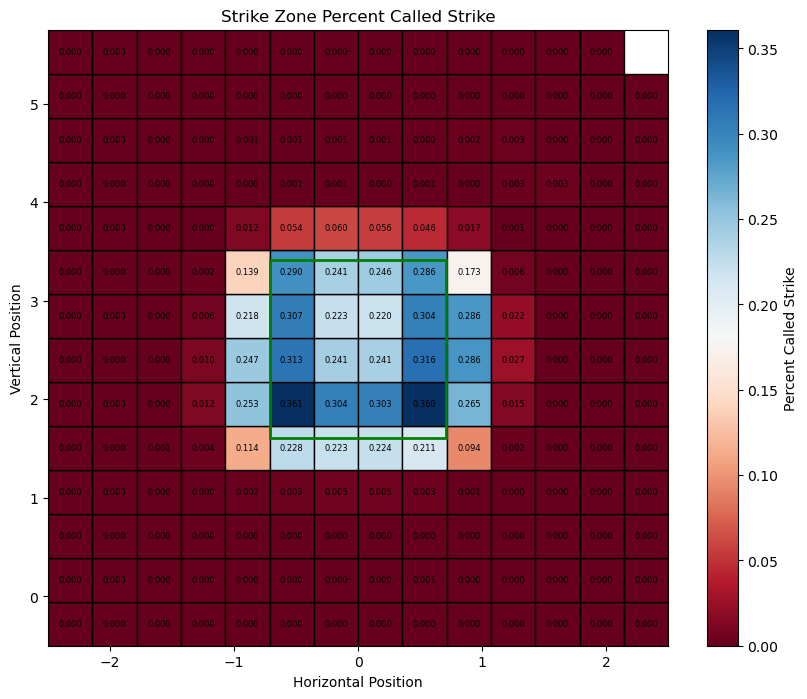

In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Normalize percentage values for the colormap
norm = plt.Normalize(zone_woba['percent_called_strike'].min(), zone_woba['percent_called_strike'].max())

# Plot each zone with its corresponding percentage value
for i in range(n_horizontal_zones):
    for j in range(n_vertical_zones):
        # Ensure that the percentage value exists for the zone
        percent_value = zone_woba.loc[(zone_woba['horizontal_zone'] == i) & (zone_woba['vertical_zone'] == j), 'percent_called_strike'].values
        if len(percent_value) > 0:
            percent_value = percent_value[0]
        else:
            percent_value = np.nan  # Set to NaN if no value exists
        
        # Calculate the coordinates of the bottom-left corner of the rectangle
        x = horizontal_zone_left + i * zone_width
        y = vertical_zone_bottom + j * zone_height
        
        # Create a rectangle patch with the calculated coordinates, width, and height
        if not np.isnan(percent_value):
            rect = patches.Rectangle((x, y), zone_width, zone_height, linewidth=1, edgecolor='black', facecolor=plt.cm.RdBu(norm(percent_value)))
            
            # Add the rectangle to the axes
            ax.add_patch(rect)
            
            # Add the percentage value as text in the center of the zone
            text_x = x + zone_width / 2
            text_y = y + zone_height / 2
            ax.text(text_x, text_y, f'{percent_value:.3f}', ha='center', va='center', color='black', fontsize=6)

# Set the limits of the axes
ax.set_xlim(horizontal_zone_left, horizontal_zone_right)
ax.set_ylim(vertical_zone_bottom, vertical_zone_top)

# Add a colorbar to show the percentage scale
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Percent Called Strike')

# Add the strike zone
strike_zone_left = -0.70833
strike_zone_right = 0.70833
strike_zone_bottom = 1.1
strike_zone_top = 3.418543422632144

strike_zone = patches.Rectangle((strike_zone_left, strike_zone_bottom), strike_zone_right - strike_zone_left, strike_zone_top - strike_zone_bottom, linewidth=2, edgecolor='green', facecolor='none')
ax.add_patch(strike_zone)

# Set labels and title
ax.set_xlabel('Horizontal Position')
ax.set_ylabel('Vertical Position')
ax.set_title('Strike Zone Percent Called Strike')

# Show the plot
plt.show()

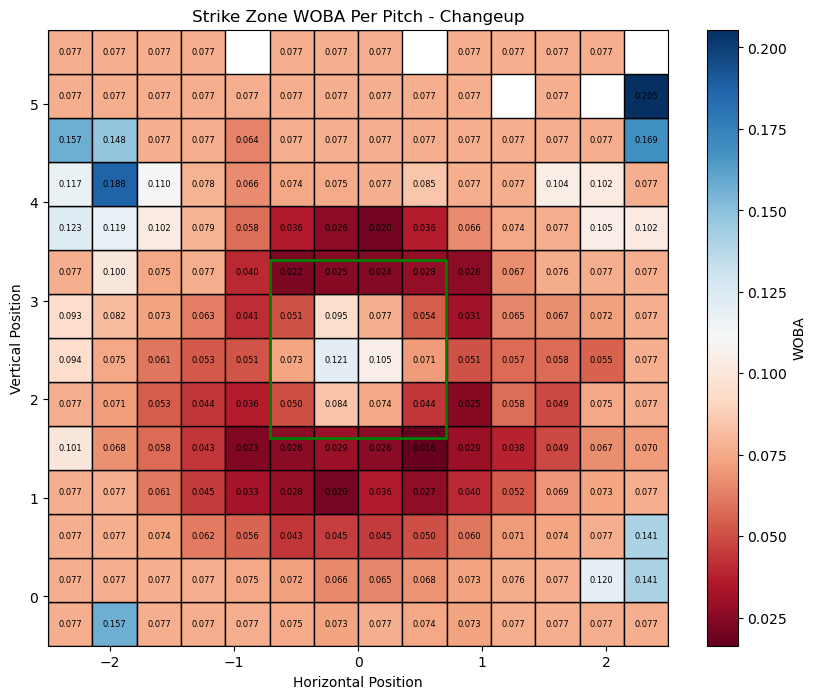

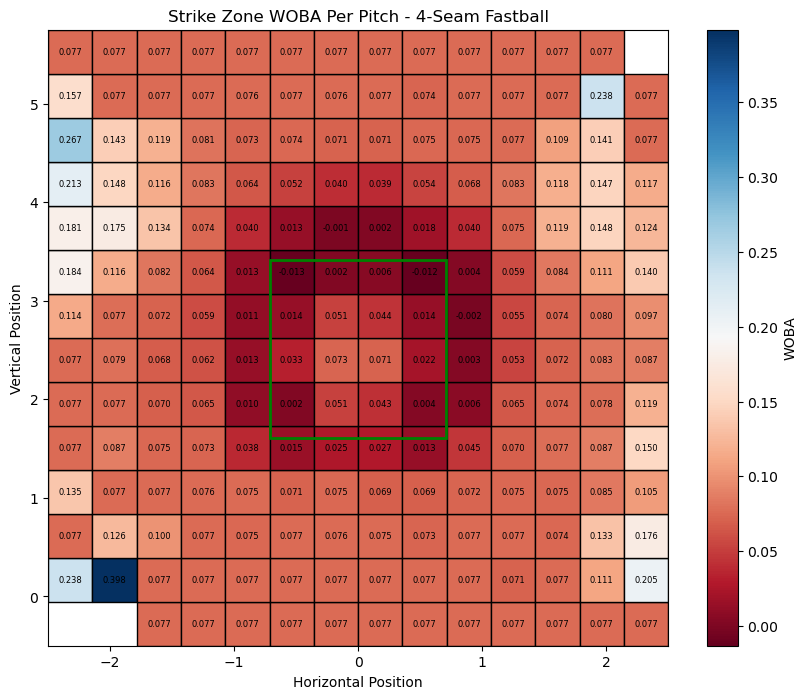

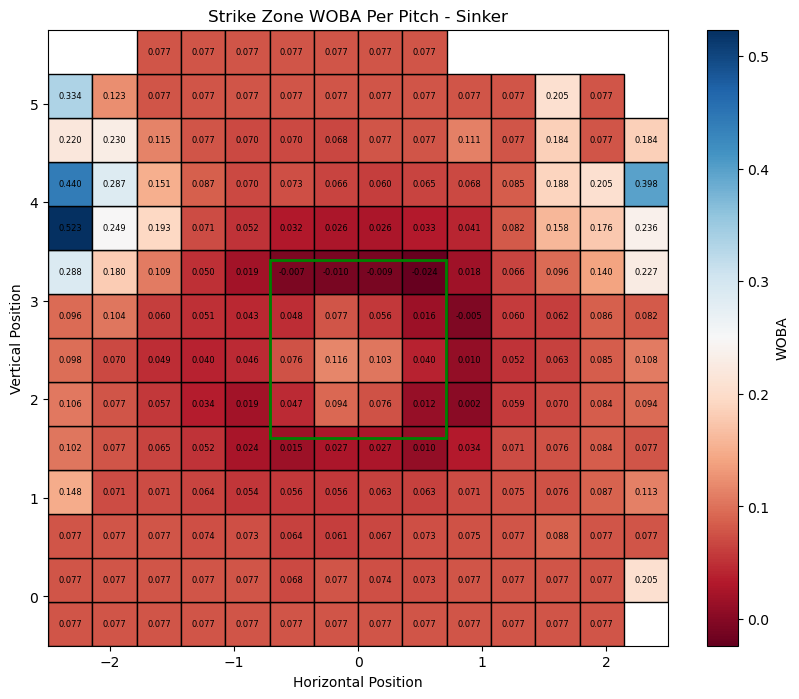

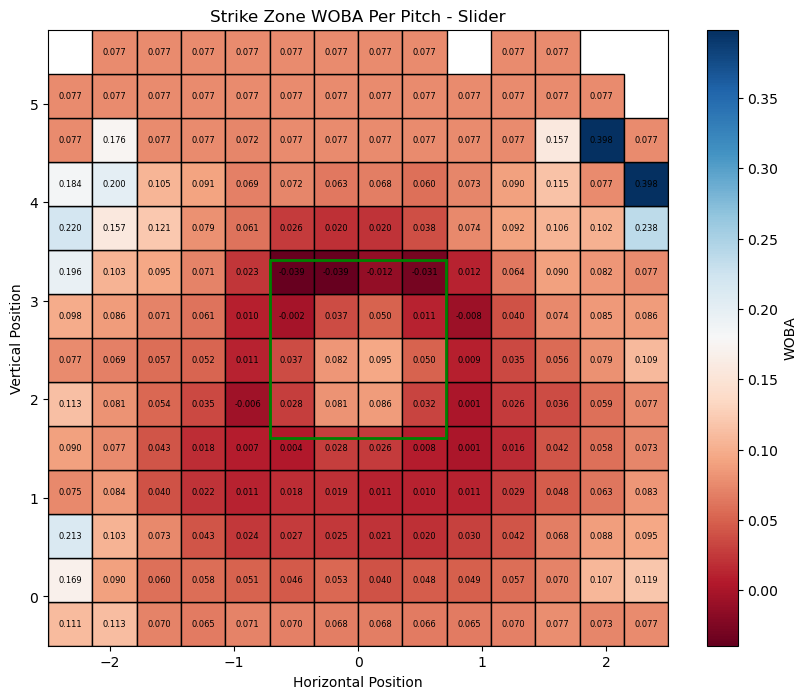

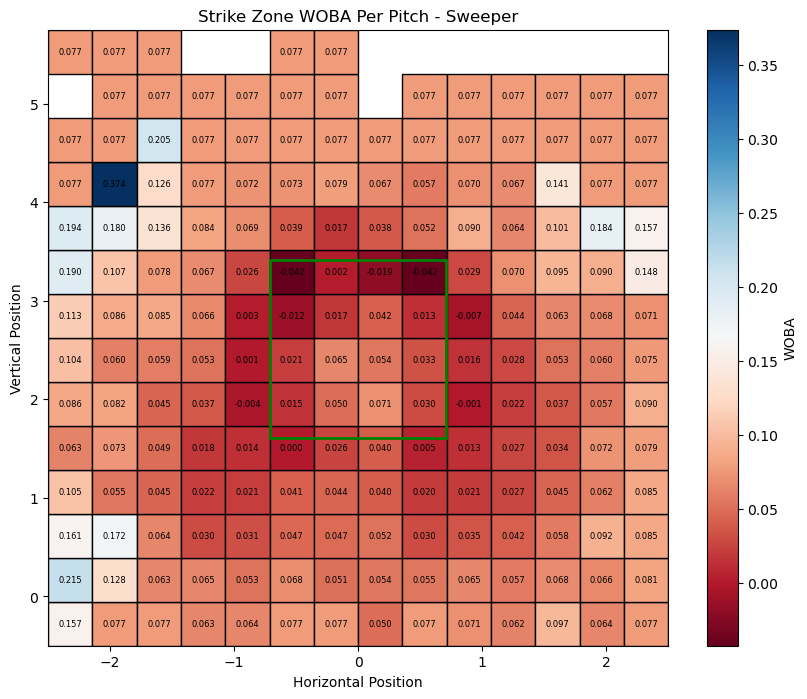

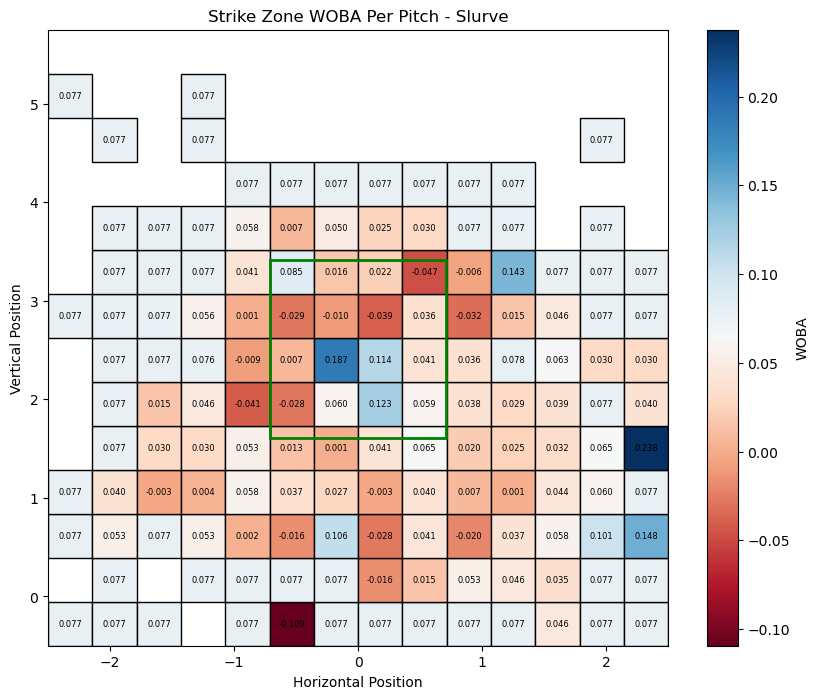

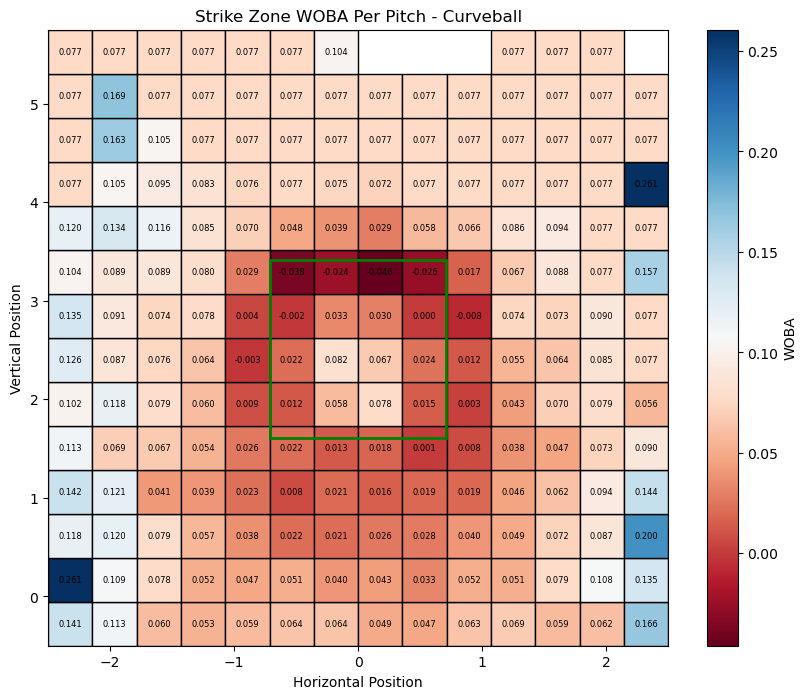

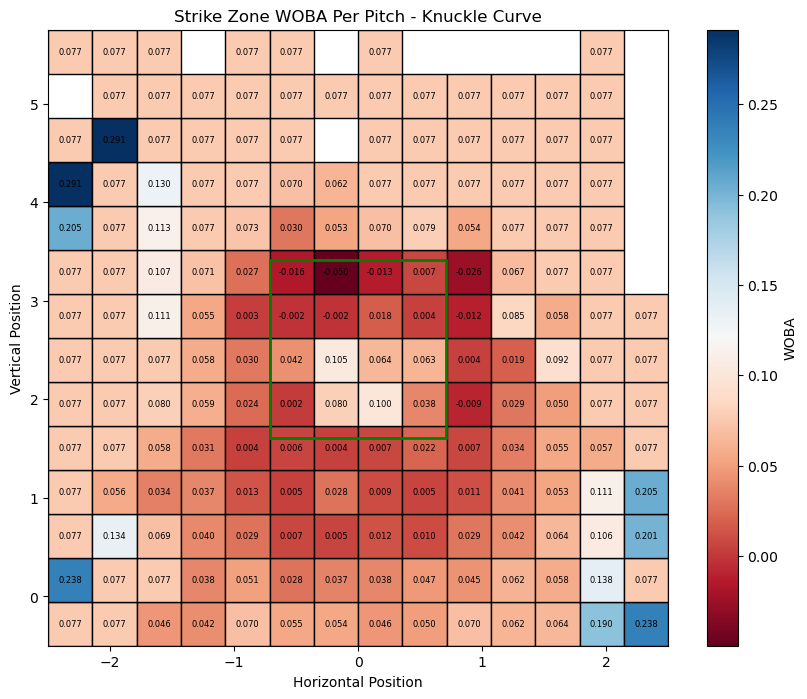

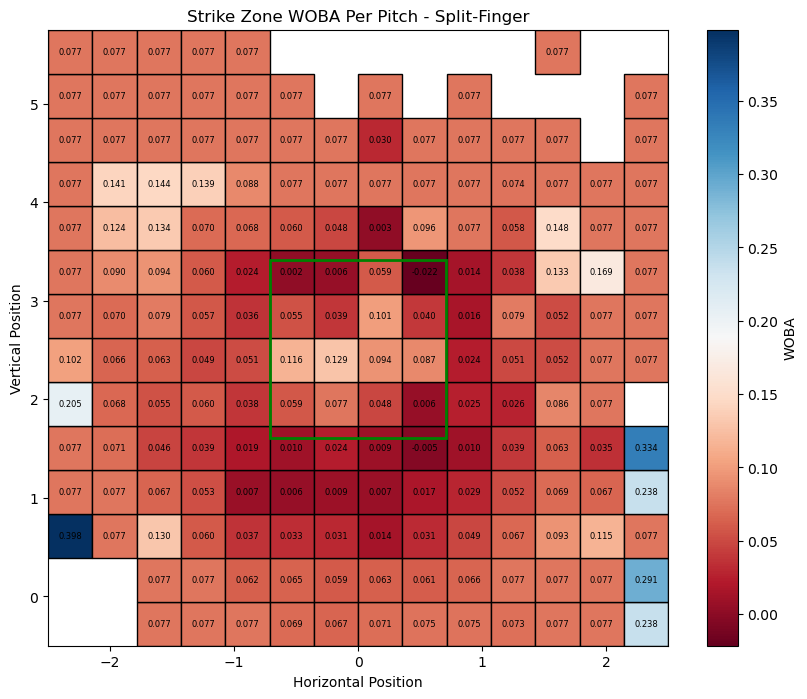

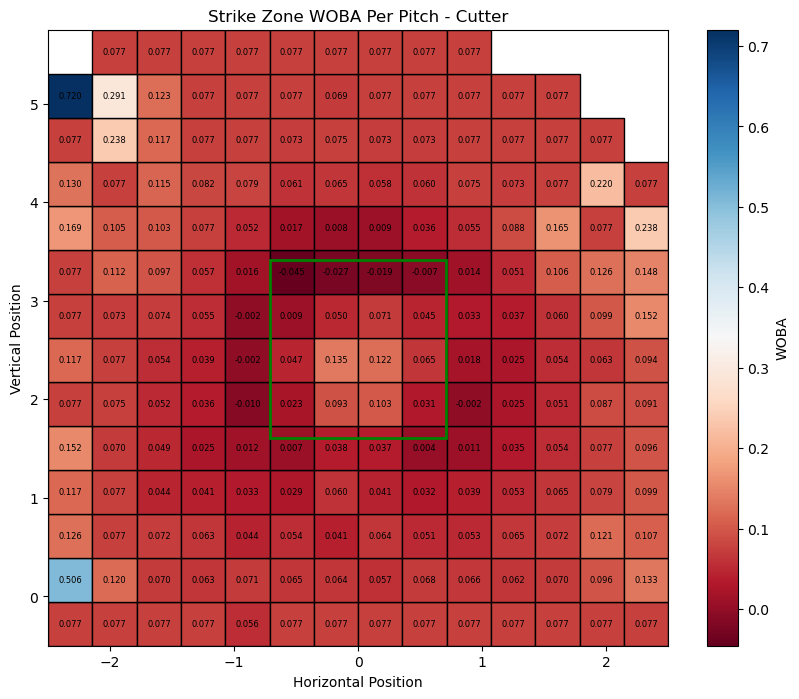

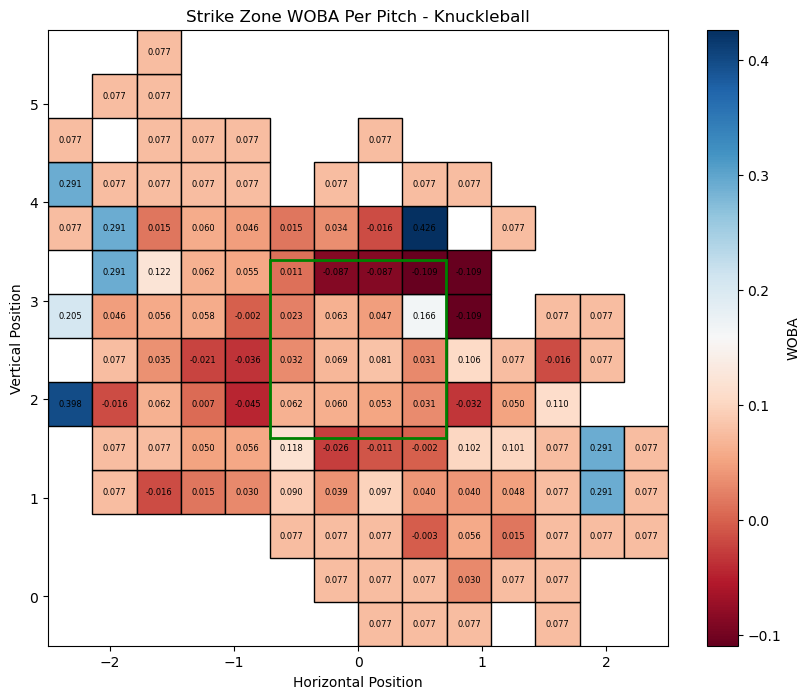

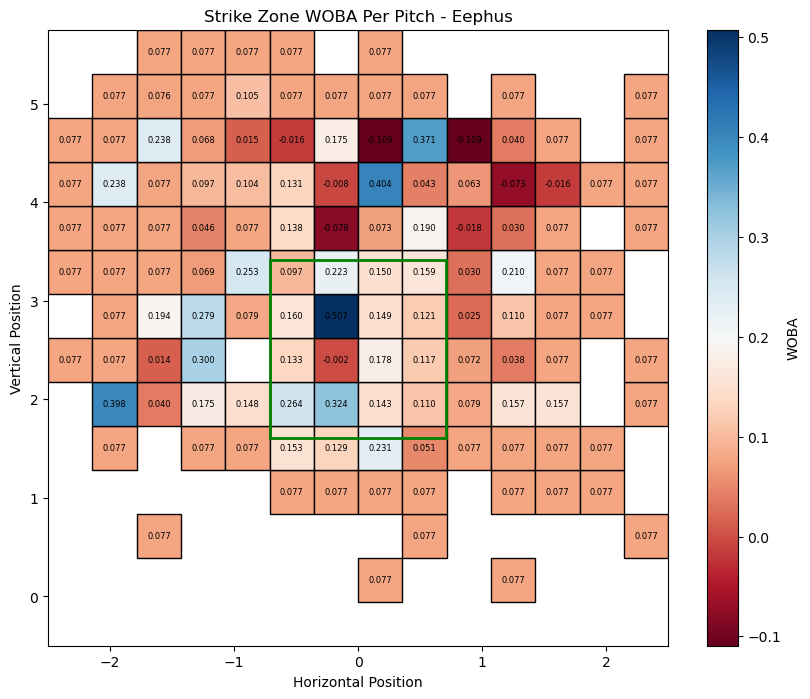

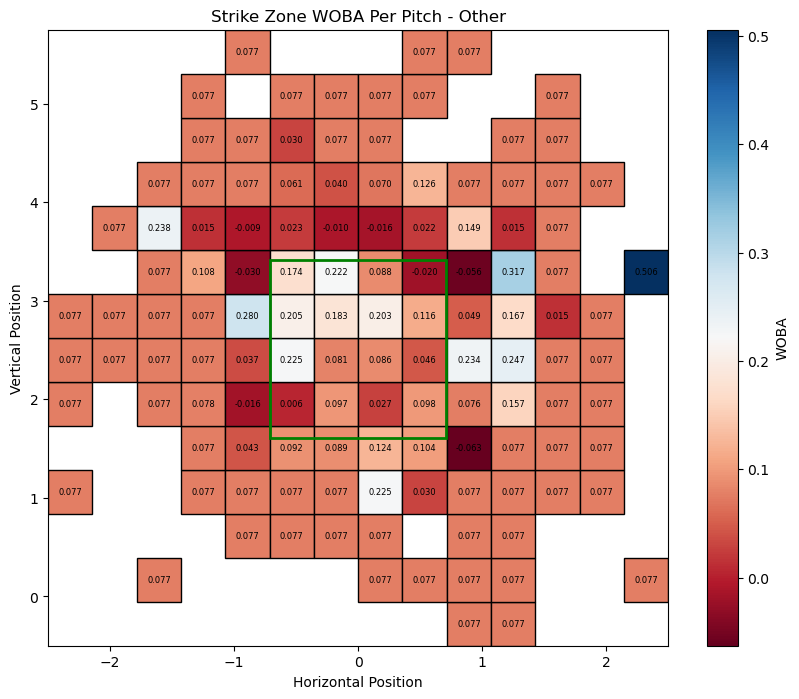

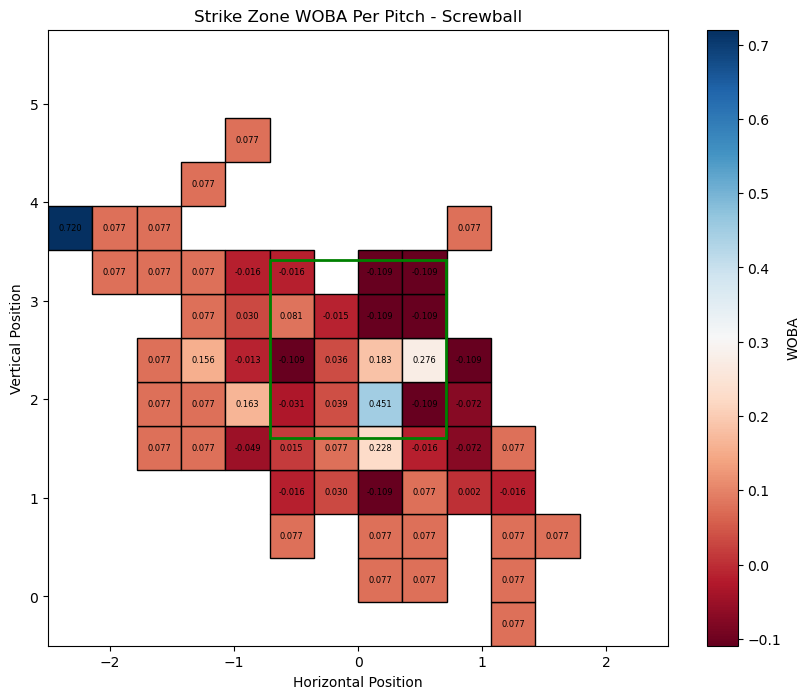

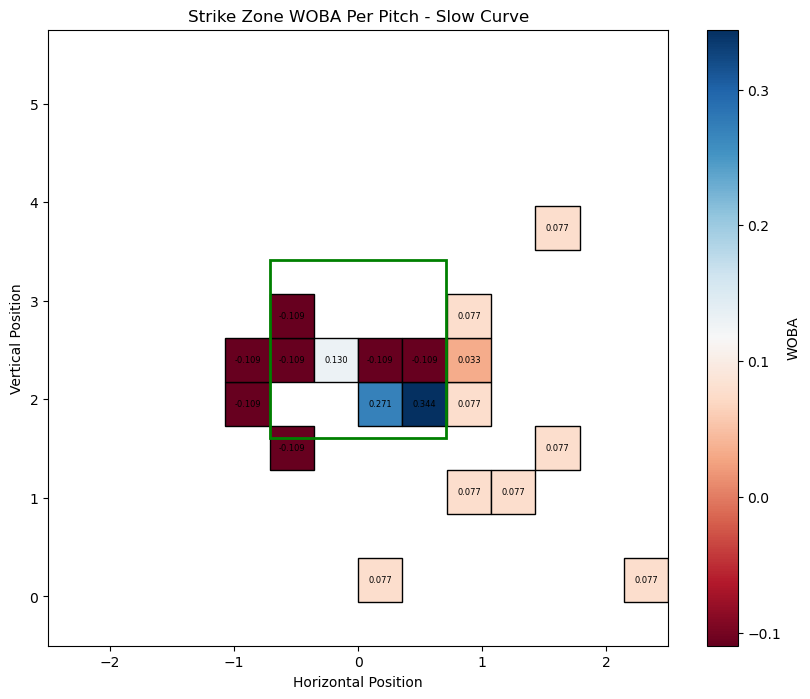

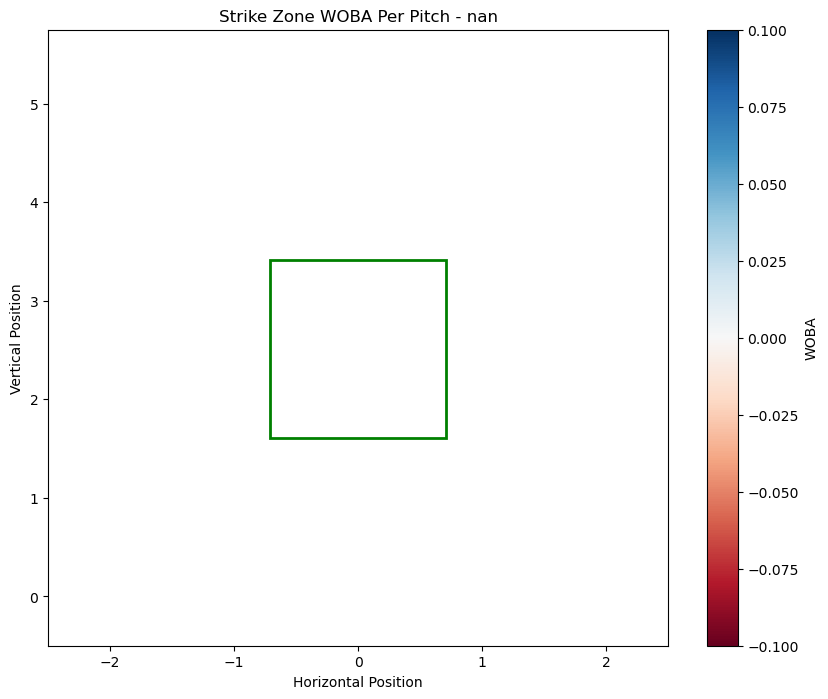

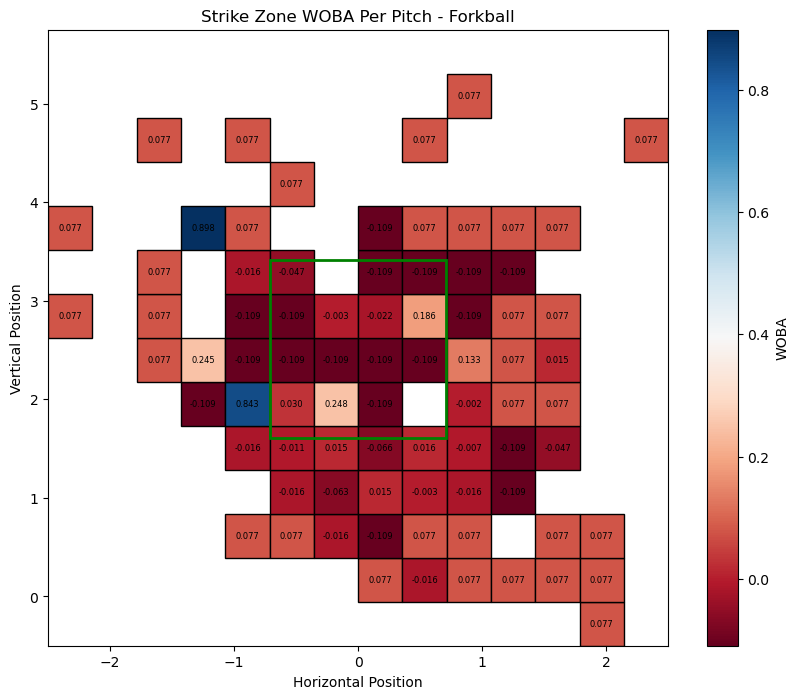

In [7]:
pitch_types = statcast_woba['pitch_name'].unique()

# Calculate zone number
statcast_woba['zone_number'] = statcast_woba['horizontal_zone'] + statcast_woba['vertical_zone'] * n_horizontal_zones

# Create a directory to save the figures directory to
if not os.path.exists('figures'):
    os.makedirs('figures')

for pitch_type in pitch_types:
    # Create a separate DataFrame for each pitch type
    statcast_pitch_type = statcast_woba[statcast_woba['pitch_name'] == pitch_type].copy()
    
    # Calculate the average WOBA for each zone
    zone_woba = statcast_pitch_type.groupby(['horizontal_zone', 'vertical_zone'])['estimated_woba'].mean().reset_index()
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Normalize WOBA values for the colormap
    norm = plt.Normalize(zone_woba['estimated_woba'].min(), zone_woba['estimated_woba'].max())

    # Plot each zone with its corresponding WOBA value
    for i in range(n_horizontal_zones):
        for j in range(n_vertical_zones):
            # Ensure that the WOBA value exists for the zone
            woba_value = zone_woba.loc[(zone_woba['horizontal_zone'] == i) & (zone_woba['vertical_zone'] == j), 'estimated_woba'].values
            if len(woba_value) > 0:
                woba_value = woba_value[0]
            else:
                woba_value = np.nan  # Set to NaN if no WOBA value exists

            # Calculate the coordinates of the bottom-left corner of the rectangle
            x = horizontal_zone_left + i * zone_width
            y = vertical_zone_bottom + j * zone_height
            
            # Create a rectangle patch with the calculated coordinates, width, and height
            if not np.isnan(woba_value):
                rect = patches.Rectangle((x, y), zone_width, zone_height, linewidth=1, edgecolor='black', facecolor=plt.cm.RdBu(norm(woba_value)))
                ax.add_patch(rect)
                # Add the WOBA value as text in the center of the zone
                text_x = x + zone_width / 2
                text_y = y + zone_height / 2
                ax.text(text_x, text_y, f'{woba_value:.3f}', ha='center', va='center', color='black', fontsize=6)

    # Set the limits of the axes
    ax.set_xlim(horizontal_zone_left, horizontal_zone_right)
    ax.set_ylim(vertical_zone_bottom, vertical_zone_top)

    # Add a colorbar to show the WOBA scale
    sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('WOBA')

    # Add the strike zone
    strike_zone_left = -0.70833
    strike_zone_right = 0.70833
    strike_zone_bottom = 1.60312824938163
    strike_zone_top = 3.418543422632144

    strike_zone = patches.Rectangle((strike_zone_left, strike_zone_bottom), strike_zone_right - strike_zone_left, strike_zone_top - strike_zone_bottom, linewidth=2, edgecolor='green', facecolor='none')
    ax.add_patch(strike_zone)

    # Set labels and title
    ax.set_xlabel('Horizontal Position')
    ax.set_ylabel('Vertical Position')
    ax.set_title(f'Strike Zone WOBA Per Pitch - {pitch_type}')

    # Save the plot to the figures folder
    plt.savefig(f'./figures/strike_zone_woba_{pitch_type}.png')

    # Show the plot
    plt.show()